We'll start by an introduction to Keras.

Most of the examples are from [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). 

## Keras and MNIST
Let us first build an introductory model for the MNIST dataset.  
More on MNIST can be found here: https://www.kaggle.com/hojjatk/mnist-dataset?msclkid=a59b1a61bffd11ec953ecf3f2a143919  
More on Layers API can be found here: https://keras.io/api/layers/?msclkid=0799043ac07911ec832b34d2444c3574  
On layers types, regularizers, initializers (beyond the Keras Layerd Documentation): https://www.tutorialspoint.com/keras/keras_layers.htm  

**Loading the MNIST dataset in Keras**

In [159]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [160]:
train_images.shape

(60000, 28, 28)

In [161]:
len(test_labels)

10000

In [162]:
train_labels[0]

np.uint8(5)

In [163]:
test_images.shape

(10000, 28, 28)

In [164]:
len(test_labels)

10000

In [165]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], shape=(10000,), dtype=uint8)

**Building the network**

So network architecture for MNIST.  
For example: https://github.com/JHP4911/htMultiple-MLP-Architectures-on-MNIST-database-using-Keras?msclkid=b0b3576ec08a11ecb731533187ed8284  
Or in the future even: https://keras.io/examples/vision/mnist_convnet/?msclkid=b0b3b888c08a11eca260b4525969c7f7  

Activation functions introduce **non-linearity**.  
Without them, deep networks reduce to linear transformations.

**ReLU (Rectified Linear Unit)**

$$
f(x) = \max(0, x)
$$

Range:
$$
[0, \infty)
$$

Use for:
- Hidden layers in most feedforward and convolutional networks  

Why useful: 
- Simple and fast  
- Helps mitigate vanishing gradients  
- Sparse activations  

Limitation: 
- Can cause “dying ReLU” (neurons stuck at 0)

**Leaky ReLU**

$$
f(x) =
\begin{cases}
x & \text{if } x > 0 \\
\alpha x & \text{if } x \le 0
\end{cases}
$$

Range:
$$
(-\infty, \infty)
$$

Use for:
- Hidden layers when ReLU leads to many inactive neurons  

Why useful:
- Keeps small gradient for negative values  
- More stable than standard ReLU  

**Sigmoid**

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

Range:
$$
(0, 1)
$$

Use for:
- Output layer in binary classification  

Why useful:
- Interpretable as probability  

Limitation:
- Vanishing gradients  
- Not suitable for deep hidden layers  

**Tanh**

$$
f(x) = \tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
$$

Range:
$$
(-1, 1)
$$

Use for:
- Some recurrent neural networks (RNNs)  
- Smaller or older architectures  

Why useful: 
- Zero-centered output  

Limitation:
- Still suffers from vanishing gradients  

**Softmax**

$$
f(x) = \tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
$$

Range (each component):
$$
(0, 1)
$$

Additionally:
$$
\sum_i f(x_i) = 1
$$

Use for:
- Output layer in multi-class classification  

Why useful:
- Produces probability distribution over classes  
- Works naturally with cross-entropy loss  

**GELU (Gaussian Error Linear Unit)**

$$
f(x) = x \Phi(x)
$$

Range:
$$
(-\infty, \infty)
$$

Use for:
- Transformer architectures (e.g., modern NLP models)  

Why useful: 
- Smooth activation  
- Empirically strong performance in large models  

**Swish**

$$
f(x) = x \frac{1}{1 + e^{-x}}
$$

Range:
$$
(-\infty, \infty)
$$

Use for:  
- Modern architectures where smooth activations are preferred  

Why useful:
- Good gradient flow  
- Sometimes outperforms ReLU  

In [138]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

Metrics are used to evaluate model performance.  
They do not guide training — they only measure the results.

**Accuracy**

$$
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}
$$

Use for: balanced classification problems  
Why useful: simple and interpretable  
Limitation: misleading with imbalanced datasets  

**Precision**

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Use for: when false positives are costly  
Why useful: measures correctness of positive predictions  

**Recall**

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Use for: when false negatives are costly  
Why useful: measures ability to detect positives  

**Mean Squared Error (MSE)**

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N}(y_i - \hat{y}_i)^2
$$

Use for: regression  
Why useful: penalizes large errors strongly  

**Mean Absolute Error (MAE)**

$$
\text{MAE} = \frac{1}{N} \sum_{i=1}^{N}|y_i - \hat{y}_i|
$$

Use for: regression  
Why useful: more robust to outliers than MSE  

**ROC-AUC**

Area under the ROC curve.

Use for: binary classification  
Why useful: measures separability independent of threshold  

Loss functions are minimized during training.  
They define the optimization objective.

**Mean Squared Error (MSE)**

$$
L = \frac{1}{N} \sum_{i=1}^{N}(y_i - \hat{y}_i)^2
$$

Use for: regression  
Why useful: smooth and differentiable  

**Mean Absolute Error (MAE)**

$$
L = \frac{1}{N} \sum_{i=1}^{N}|y_i - \hat{y}_i|
$$

Use for: regression  
Why useful: less sensitive to outliers  

**Binary Cross-Entropy (BCE)**

$$
L = - \frac{1}{N} \sum_{i=1}^{N}
\left[
y_i \log(\hat{y}_i) + (1 - y_i)\log(1 - \hat{y}_i)
\right]
$$

Use for: binary classification  
Why useful: works naturally with sigmoid outputs  

**Categorical Cross-Entropy**

$$
L = - \sum_{i=1}^{K} y_i \log(\hat{y}_i)
$$

Use for: multi-class classification  
Why useful: works with softmax outputs  

**Hinge Loss**

$$
L = \max(0, 1 - y \hat{y})
$$

Use for: margin-based classification (SVM-style models)  
Why useful: encourages separation margin  

**KL Divergence**

$$
D_{KL}(P \| Q) = \sum_i P(i) \log \frac{P(i)}{Q(i)}
$$

Use for: comparing probability distributions  
Why useful: common in generative models and VAEs  

In [139]:
model.compile(optimizer="adamax",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [140]:
model

<Sequential name=sequential_5, built=False>

**Preparing the image data**

In [141]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

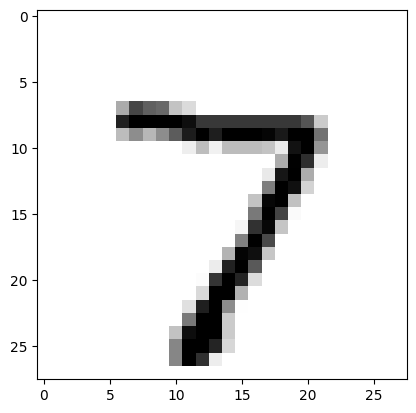

In [142]:
import matplotlib.pyplot as plt
digit = test_images[0].reshape(28, 28)
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

**"Fitting" the model**

In [143]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6312 - loss: 1.8747
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7825 - loss: 1.0182
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8372 - loss: 0.6780
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8647 - loss: 0.5353
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8792 - loss: 0.4626


**Using the model to make predictions**

In [144]:
test_digits = test_images[0:10]
predictions = model(test_digits)

In [145]:
predictions[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.61205448e-04, 5.84136160e-06, 6.14488890e-05, 6.98857184e-04,
       1.05951025e-04, 2.18515459e-04, 1.07934943e-06, 9.90375340e-01,
       9.04471235e-05, 8.28124210e-03], dtype=float32)>

In [146]:
predictions[0][7]

<tf.Tensor: shape=(), dtype=float32, numpy=0.9903753399848938>

In [147]:
test_labels[0]

np.uint8(7)

**Evaluating the model on new data**

In [148]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"test_acc: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8901 - loss: 0.4222
test_acc: 0.8901000022888184


### Reimplementing our first example from scratch in TensorFlow

![Keras vs. Tensorflow](../img/keras-tensorflow.png)

#### A simple Dense class

In [149]:
import tensorflow as tf

class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]

#### A simple Sequential class

In [150]:
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
           x = layer(x)
        return x

    @property
    def weights(self):
       weights = []
       for layer in self.layers:
           weights += layer.weights
       return weights

In [151]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

#### A batch generator

In [152]:
import math

class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        assert len(images) == len(labels)
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(images) / batch_size)

    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

### Running one training step

In [153]:
def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        predictions = model(images_batch)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(
            labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
    gradients = tape.gradient(average_loss, model.weights)
    update_weights(gradients, model.weights)
    return average_loss

In [154]:
learning_rate = 1e-3

def update_weights(gradients, weights):
    for g, w in zip(gradients, weights):
        w.assign_sub(g * learning_rate)

In [155]:
from tensorflow.keras import optimizers

optimizer = optimizers.SGD(learning_rate=1e-3)

def update_weights(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

### The full training loop

In [156]:
def fit(model, images, labels, epochs, batch_size=128):
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(images, labels)
        for batch_counter in range(batch_generator.num_batches):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss:.2f}")

In [157]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

fit(model, train_images, train_labels, epochs=10, batch_size=128)

Epoch 0
loss at batch 0: 5.02
loss at batch 100: 2.24
loss at batch 200: 2.21
loss at batch 300: 2.11
loss at batch 400: 2.22
Epoch 1
loss at batch 0: 1.92
loss at batch 100: 1.89
loss at batch 200: 1.84
loss at batch 300: 1.73
loss at batch 400: 1.84
Epoch 2
loss at batch 0: 1.60
loss at batch 100: 1.59
loss at batch 200: 1.52
loss at batch 300: 1.45
loss at batch 400: 1.52
Epoch 3
loss at batch 0: 1.34
loss at batch 100: 1.35
loss at batch 200: 1.26
loss at batch 300: 1.23
loss at batch 400: 1.28
Epoch 4
loss at batch 0: 1.14
loss at batch 100: 1.16
loss at batch 200: 1.06
loss at batch 300: 1.07
loss at batch 400: 1.11
Epoch 5
loss at batch 0: 0.99
loss at batch 100: 1.02
loss at batch 200: 0.92
loss at batch 300: 0.95
loss at batch 400: 0.99
Epoch 6
loss at batch 0: 0.88
loss at batch 100: 0.92
loss at batch 200: 0.82
loss at batch 300: 0.86
loss at batch 400: 0.90
Epoch 7
loss at batch 0: 0.80
loss at batch 100: 0.83
loss at batch 200: 0.74
loss at batch 300: 0.79
loss at batch 40

### Evaluating the model

In [158]:
import numpy as np
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")

accuracy: 0.81
